<a href="https://colab.research.google.com/github/MichaelCondo/Team9-APS360-Project/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check Yo' Self Demo
**Self-serve checkout enhancement using Neural Networks and Deep Learning**

## Architecture
![alt text](https://github.com/MichaelCondo/Team9-APS360-Project/blob/main/docs/Architecture_Diagram.png?raw=true)

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Seed for reproducible results
np.random.seed(1000)
torch.manual_seed(1000)
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## Load Dataset & Mappings

In [2]:
# Download the dataset from GitHub
!wget -nc https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip \
    && mkdir -p "/root/project" \
    && unzip -nq "master.zip" -d "/root/project/datasets" \
    && find "/root/project/datasets/" -mindepth 2 -maxdepth 2 -type d -ls
DATA_MASTER_PATH = "/root/project/datasets/Fruit-Images-Dataset-master"

--2020-12-04 17:13:54--  https://github.com/Horea94/Fruit-Images-Dataset/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/master [following]
--2020-12-04 17:13:54--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [              <=>   ] 761.30M  30.3MB/s    in 33s     

2020-12-04 17:14:27 (23.3 MB/s) - ‘master.zip’ saved [798281939]

  2243623      4 drwxr-xr-x   2 root     root         4096 Sep  9 15:32 /root/project/datasets/Fruit-Images-Dataset-master/test-multip

In [3]:
import requests

CLASS_MAPPING = requests.get("https://raw.githubusercontent.com/MichaelCondo/Team9-APS360-Project/main/mappings/original_to_new_class.json").json()
CLASS_PRICES = requests.get("https://raw.githubusercontent.com/MichaelCondo/Team9-APS360-Project/main/mappings/class_to_price.json").json()

## Count Samples

In [4]:
!echo "Training samples" && find "{DATA_MASTER_PATH}/Training" -type f | wc -l 
!echo "Testing samples" && find "{DATA_MASTER_PATH}/Test" -type f | wc -l 
!echo "Multiple Fruits Testing samples" && find "{DATA_MASTER_PATH}/test-multiple_fruits" -type f | wc -l 

!echo "Training samples class distribution" \
    && cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

Training samples
67692
Testing samples
22688
Multiple Fruits Testing samples
103
Training samples class distribution
    984 ./Grape Blue
    900 ./Plum 3
    738 ./Tomato 3
    738 ./Tomato 1
    738 ./Strawberry Wedge
    738 ./Peach 2
    738 ./Melon Piel de Sapo
    738 ./Cherry Rainier
    738 ./Cherry 2
    735 ./Walnut
...
    438 ./Onion White
    429 ./Apple Red 3
    427 ./Avocado
    426 ./Mango Red
    420 ./Plum 2
    392 ./Cucumber Ripe
    367 ./Tomato Maroon
    300 ./Pear Kaiser
    300 ./Mangostan
    297 ./Ginger Root


## PreProcess Dataset

In [5]:
import os
import shutil

for dataset_type in ["Training", "Test", "test-multiple_fruits"]:
    for f in os.scandir(f"{DATA_MASTER_PATH}/{dataset_type}"):
        if f.is_dir() and f.name not in CLASS_MAPPING:
            shutil.rmtree(f.path)
            print("Removed", dataset_type, "/", f.name)

!cd "{DATA_MASTER_PATH}/Training" \
    && find -maxdepth 2 -mindepth 2 -type f -printf "%h\0" \
    | uniq -zc | tr '\0' '\n' | sort -rh  \
    | (sed -u 10q ; echo "..." ; tail)

Removed Training / Nut Pecan
Removed Training / Strawberry Wedge
Removed Training / Cherry 1
Removed Training / Cherry 2
Removed Training / Redcurrant
Removed Training / Blueberry
Removed Training / Huckleberry
Removed Training / Cherry Rainier
Removed Training / Cherry Wax Black
Removed Training / Grape Blue
Removed Training / Banana Lady Finger
Removed Training / Strawberry
Removed Training / Grape White 4
Removed Training / Grape Pink
Removed Training / Raspberry
Removed Training / Banana
Removed Training / Chestnut
Removed Training / Walnut
Removed Training / Nut Forest
Removed Training / Cherry Wax Red
Removed Training / Cherry Wax Yellow
Removed Training / Grape White
Removed Training / Grape White 3
Removed Training / Mulberry
Removed Training / Hazelnut
Removed Training / Banana Red
Removed Training / Grape White 2
Removed Test / Nut Pecan
Removed Test / Strawberry Wedge
Removed Test / Cherry 1
Removed Test / Cherry 2
Removed Test / Redcurrant
Removed Test / Blueberry
Removed T

## Data Loading

In [6]:
class RemappedImageFolder(torchvision.datasets.ImageFolder):
    """Subclass of ImageFolder that lets you remap your classes at parse time
    instead of through target_transform (which would be applied on every getitem)
    """

    def __init__(self, class_remapping, **kwargs):
        self.class_remapping = class_remapping
        super(RemappedImageFolder, self).__init__(**kwargs)

    def _find_classes(self, dir):
        """Override ImageFolder's class identification method so we can
        do custom consolidation of our classes.
        See https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
        """
        # Get the original classes (i.e. folder names)
        o_classes = super()._find_classes(dir)[0]

        # Get our classes (from the JSON mapping)
        classes = list(sorted(set(self.class_remapping.values())))

        # Create an index for only our new classes
        new_class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Map the old classes to their indices in our new system
        real_class_to_idx = {
            old_class: new_class_to_idx[self.class_remapping[old_class]]
            for old_class in o_classes
        }

        return classes, real_class_to_idx

In [7]:
class RandomBackgroundRecolour():
    """Augment image by modifying background colour to something random."""

    def __call__(self, pic):
        replacement_color = (
            np.random.randint(64, 128),
            np.random.randint(0, 64),
            np.random.randint(0, 64),
        )

        img = pic.convert("RGB")
        data = np.array(img)

        data[(data[:,:,0]>=240) & (data[:,:,1]>=240) & (data[:,:,2]>=240)] = replacement_color
        return Image.fromarray(data, mode="RGB")

In [8]:
from sklearn.model_selection import train_test_split

def get_data_loaders(batch_size=1, num_workers=1):
    """Loads images of produce, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        batch_size: A int representing the number of samples per batch (<1 means 
        use the full dataset in every batch)
    
    Returns:
        train_loader: iterable training dataset (from training data)
        val_loader: iterable validation dataset (from training data)
        test_loader: iterable testing dataset (from test data)
        classes: A list of strings denoting the name of each class
    """
    ########################################################################
    # We'll return a (train, val, test, classes) tuple
    classes = list(sorted(set(CLASS_MAPPING.values())))

    # Load datasets
    train_set = RemappedImageFolder(
        class_remapping=CLASS_MAPPING,
        root=f"{DATA_MASTER_PATH}/Training",
        transform=transforms.Compose(
            [
                transforms.RandomApply(
                    [
                        transforms.RandomAffine(0, scale=[0.5, 1.5], fillcolor=(255,255,255)),
                        RandomBackgroundRecolour(),
                        transforms.ColorJitter(brightness=(1, 1.1), contrast=(1, 1.5)),
                    ],
                    p=0.80,
                ),
                transforms.Resize((100, 100)),
                transforms.ToTensor(),
            ]
        ),
    )

    test_set = RemappedImageFolder(
        class_remapping=CLASS_MAPPING,
        root=f"{DATA_MASTER_PATH}/Test",
        transform=transforms.Compose(
            [transforms.Resize((100, 100)), transforms.ToTensor()]
        ),
    )

    # Split train/validation data with stratification of classes
    train_idx, val_idx = train_test_split(
        np.arange(len(train_set.targets)),
        test_size=0.3,
        shuffle=True,
        stratify=train_set.targets
    )

    train_set, val_set = [
        torch.utils.data.Subset(train_set, idx)
        for idx in [train_idx, val_idx]
    ]

    # Create and return the data loaders
    bs = len(train_set) if batch_size < 1 else batch_size
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )
    
    bs = len(val_set) if batch_size < 1 else batch_size
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )
    
    bs = len(test_set) if batch_size < 1 else batch_size
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=bs, num_workers=num_workers, shuffle=True
    )

    return train_loader, val_loader, test_loader, classes

Found 37034 Training examples
Found 15872 Validation examples
Found 17731 Test examples
There are 88 classes
Training set looks like:


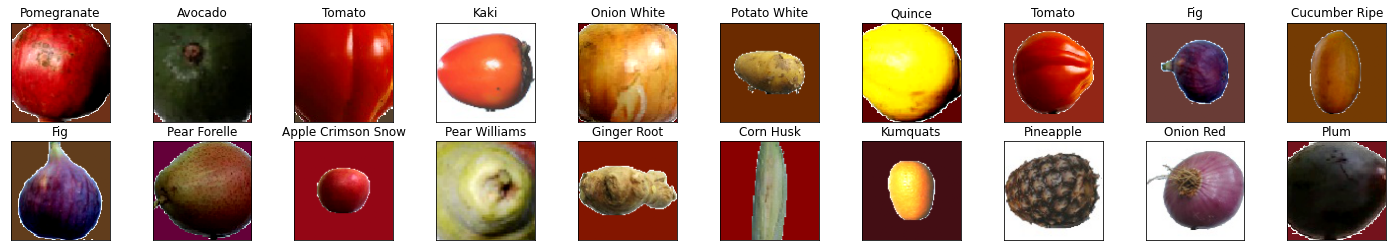

In [9]:
# Count the samples
for kind, loader in zip(["Training", "Validation", "Test"], get_data_loaders()[:3]):
    print(f"Found {len(loader)} {kind} examples")

# Prepare dataloaders for real
train_loader, val_loader, test_loader, classes = get_data_loaders(
    batch_size=27  # we know that this is a divisor of the number of submissions
)

print("There are", len(classes), "classes")

print("Training set looks like:")
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Model Setup

In [10]:
class CNN(nn.Module):
    """
    A simple CNN classifier that takes a list of output classes on init
    to determine the output layer size. Assumes an input of size nx3x100x100.
    """
    def __init__(self, output_classes):
        super(CNN, self).__init__()
        num_outputs = len(output_classes)
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 2, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 250),
            nn.ReLU(),
            nn.Linear(250, num_outputs)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 4 * 4)
        x = self.classifier(x)
        return x

In [11]:
model = CNN(classes)
# See if dimensions are okay
model(torch.randn((64, 3, 100, 100)))

# See model stats
print(model.__class__.__name__, "parameters:", sum(p.numel() for p in model.parameters()))
print(model)

CNN parameters: 288882
CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=88, bias=True)
  )
)


## Model Training

In [12]:
def get_model_name(model, batch_size=1, learning_rate=1e-3, iteration=0):
    """Generate a name for the model with the hyperparameter values"""
    return "model_{0}_bs{1}_lr{2}_checkpoint{3}".format(
        model.__class__.__name__, batch_size, learning_rate, iteration
    )


def evaluate(model, data_loader, criterion=None):
    """Evaluate the model (accuracy, loss) on the given dataset
    If critierion is not provided, only accuracy will be computed.
    """
    correct, total = 0, 0
    total_loss = 0.0
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Calculate batch
        outputs = model(inputs)

        # Correctness: select index with maximum prediction score
        pred = outputs.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += pred.shape[0]

        # Optional loss computation
        if criterion:
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    if criterion:
        return correct / total, total_loss / len(data_loader)
    else:
        return correct / total


def plot_training_curve(path):
    """ Plots accuracy/loss curves for a model run given the CSV path"""
    import matplotlib.pyplot as plt

    iterations, train_acc, val_acc, train_loss, val_loss = np.loadtxt(
        f"{model_path}_training.csv"
    ).T

    plt.title("Train vs Validation Accuracy")
    plt.plot(iterations, train_acc, label="Train")
    plt.plot(iterations, val_acc, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(iterations, train_loss, label="Train")
    plt.plot(iterations, val_loss, label="Validation")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

    print(
        "Best Training Accuracy: {:.2f}% @ checkpoint {:.0f}".format(
            max(train_acc) * 100, iterations[np.argmax(train_acc)]
        )
    )
    print(
        "Best Validation Accuracy: {:.2f}% @ checkpoint {:.0f}".format(
            max(val_acc) * 100, iterations[np.argmax(val_acc)]
        )
    )

In [13]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

In [14]:
folder_download('1lAY-oPH5YRqYI4-OrWMNsju6iRU-GlrI')

1-Kvfzp9rzD9Ykekd4m1n0Hy5cx8RY9eH model_CNN_bs27_lr0.001_checkpoint10976 application/x-zip (1/22)
Download 100%.
1-L2zorWDoL0BudtJj8X710CBEPWXRiLt model_CNN_bs27_lr0.001_checkpoint12348 application/x-zip (2/22)
Download 100%.
1fPOOIbNDYgxGmZHYjYwClZf7OUcS4l7y model_CNN_bs27_lr0.001_checkpoint1372 application/x-zip (3/22)
Download 100%.
1-MZzo7TkwOrWIR8oNllMnd1dDb3FJZmE model_CNN_bs27_lr0.001_checkpoint13720 application/x-zip (4/22)
Download 100%.
1-LeflaR1yb0x-0jmnx3-x78KtaoO6Rzi model_CNN_bs27_lr0.001_checkpoint13720_training.csv text/csv (5/22)
Download 100%.
1-0RWqgqV4y9tdkG6g6jQzPr526suEV8u model_CNN_bs27_lr0.001_checkpoint2744 application/x-zip (6/22)
Download 100%.
1-1Vd0Z9bd1AcGXeBwHrva-KkhrzAp7Dp model_CNN_bs27_lr0.001_checkpoint4116 application/x-zip (7/22)
Download 100%.
1-7jX_AdgXyotd3UELFdHIGIAGPJEaW_x model_CNN_bs27_lr0.001_checkpoint5488 application/x-zip (8/22)
Download 100%.
1-CKeQOTgIP3ShxgDMNGEMOhrNFAc2q7q model_CNN_bs27_lr0.001_checkpoint6860 application/x-zip (9/22)

'model_checkpoint'

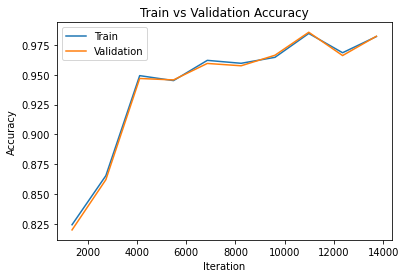

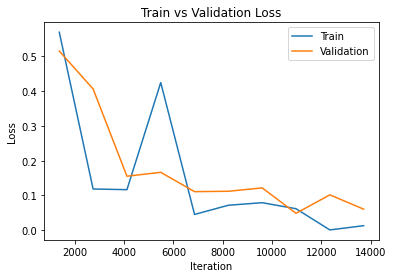

Best Training Accuracy: 98.46% @ checkpoint 10976
Best Validation Accuracy: 98.56% @ checkpoint 10976


In [19]:
%cd model_checkpoint
model = CNN(classes)
model_path = get_model_name(model, 27, 0.001, 13720)
plot_training_curve(model_path)

In [20]:
%cd model_checkpoint
model = CNN(classes)

model.load_state_dict(torch.load(get_model_name(model, 27, 0.001, 10976)))
if torch.cuda.is_available():
    model.cuda()

test_acc = evaluate(model, get_data_loaders(-1)[2])
print("Testing Accuracy: {:.2f}%".format(test_acc * 100))

Testing Accuracy: 91.59%


Test set verification:


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


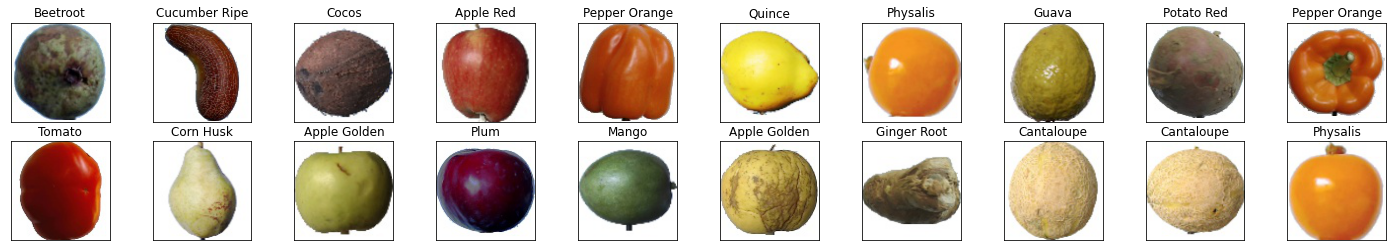

In [21]:
print("Test set verification:")

# Obtain one batch of test images
dataiter = iter(get_data_loaders(-1, 0)[2])
images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# for image in images:
#   print(type(image))
#   break
out = model(images.cuda())
pred = out.max(1, keepdim=True)[1]
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[pred[idx]])

## Object Localization and Classification



In [ ]:
import torchvision
import cv2
from PIL import Image
from torchvision.transforms import ToTensor
from matplotlib import cm
!pip install ffmpy

In [ ]:
model_restNet = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_restNet.eval()

In [ ]:
# Give an image and get the bounding boxes 
def get_prediction(img_path, threshold, open=False):
  if open:
    img = Image.open(img_path) # Load the image
  else:
    img = img_path
  transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model_restNet([img]) # Pass the image to the model
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold] # Get list of index with score greater than threshold.

  if len(pred_t) > 0:
    pred_t = pred_t[-1]
    pred_boxes = pred_boxes[:pred_t+1]
    return pred_boxes
  else:
    pred_t = 0
    return []
  

# Crop each image with the bounding boxes 
def seg_img (img_path, boxes, plot=False, open=False):
  img_list = []
  for i in range(len(boxes)):
    if open:
      im = Image.open(img_path) 
    else:
      im = img_path
      im = Image.fromarray(np.uint8(im)).convert('RGB')  #convert numpy array to PIL image
    im = im.crop((boxes[i][0][0], boxes[i][0][1], boxes[i][1][0], boxes[i][1][1]))
    img_list.append(im)
    if plot:
      plt.imshow(im)
      plt.show()
  return img_list

# ref: https://stackoverflow.com/questions/44231209/resize-rectangular-image-to-square-keeping-ratio-and-fill-background-with-black/44231784
def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def classify_cropped_images(seg_img_list, plot=False):
  images = []
  for im in seg_img_list:
    im = make_square(im, fill_color=(255, 255, 255, 0))
    im = im.resize((100, 100)) # #Resize Image to 100, 100
    im = ToTensor()(im) # #convert PIL image to tensor
    images.append(im)

  images = torch.stack(images)
  model = CNN(classes)
  model.load_state_dict(torch.load(get_model_name(model, 27, 1e-3, 13720)))

  if torch.cuda.is_available():
      model.cuda()
  out = model(images.cuda())
  pred = out.max(1, keepdim=True)[1]
  images = images.numpy()               # convert images to numpy for display

  # plot the images in the batch, along with the corresponding labels
  if plot:
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(len(pred)):
        ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[pred[idx]])
  
  predictionClasses = []
  for p in pred:
    predictionClasses.append(classes[p])
  return predictionClasses

def object_detection_api(img_path, open=False, plot=False, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  boxes = get_prediction(img_path, threshold, open) # Get predictions
  pred_cls = []

  if len(boxes) > 0:
    seg_img_list = seg_img(img_path, boxes, plot, open)
    pred_cls = classify_cropped_images(seg_img_list, plot)

  new_boxes = []
  for box in boxes:
    new_box = [box[0][0], box[0][1], box[1][0], box[1][1]]
    new_boxes.append(new_box)

  return new_boxes, pred_cls

In [ ]:
%cd '/content/drive/MyDrive/APS360 Project/model_checkpoint'
boxes, pred_cls = object_detection_api('/root/project/datasets/Fruit-Images-Dataset-master/test-multiple_fruits/apple_pear.jpg', open=True, plot=False, threshold=0.5)

### Receipt Creation

In [ ]:
def create_receipt(pred_cls):
  """
    cust_cart = {'apple': ['count', 'price']}
  """
  cust_cart = {}
  for pred in pred_cls:
    if pred in cust_cart:
      cust_cart[pred][0] += 1
    else:
      cust_cart[pred] = []
      cust_cart[pred].append(1) 
      cust_cart[pred].append(CLASS_PRICES[pred]) 
  return cust_cart

In [ ]:
cart = create_receipt(pred_cls)
subtotal = 0
for fruit, info in cart.items():
  price = round(info[0] * info[1], 2)
  print(fruit + ": " + str(info[0]))
  print("\t" + str(info[0]) + " x " + str(price) + "\t$" + str(price))
  subtotal += price

subtotal = round(subtotal, 2)
print("\nSubtotal: $" + str(subtotal))

tax = 1.13
total = round(subtotal * tax, 2)
print("Total: $" + str(total))

## Detecting Objects in Videos


In [ ]:
classes = list(sorted(set(CLASS_MAPPING.values())))
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
def draw_boxes(boxes, preds, image):
    # read the image with OpenCV
    for i, box in enumerate(boxes):
        pred_idx = classes.index(preds[i])
        color = COLORS[pred_idx]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 4
        )
        cv2.putText(image, preds[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 1, 
                    lineType=cv2.LINE_AA)
    return image

In [ ]:
import cv2
import numpy as np

## remove previous files to avoid overlap
%cd '/content/drive/MyDrive/APS360 Project/output'
!rm -r output.avi
!rm -r output.mp4
!ls 

# reset directory to model checkpoints
%cd '/content/drive/MyDrive/APS360 Project/model_checkpoint'

# All the test video
test_vids_paths = [ '/content/drive/MyDrive/APS360 Project/fruit_video_Trim.mp4',
                    '/content/drive/MyDrive/APS360 Project/Fruit_Vid_001.mp4'          
                  ]

# Set path for your test vid
vid_path = test_vids_paths[1]

# Create a VideoCapture object
cap = cv2.VideoCapture(vid_path)

# Check if camera opened successfully
if (cap.isOpened() == False): 
  print("Unable to read camera feed")

# Create VideoWriter object and write to output file "output.avi"
out_dim_x = 1280
out_dim_y = 720
out = cv2.VideoWriter('/content/drive/MyDrive/APS360 Project/output/output.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (out_dim_x, out_dim_y))

# Number of frames in the video
print(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

while(cap.isOpened()):
  ret, frame = cap.read()

  if ret == True: 
    with torch.no_grad():
        frame = cv2.resize(frame, (out_dim_x, out_dim_y))
        boxes, preds = object_detection_api(frame)
        
    # Draw boxes around dtected objects in current frame
    if len(boxes) > 0:
      image = draw_boxes(boxes, preds, frame)
      out.write(image)  # Write the frame into the file 'output.avi'

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Break the loop
  else:
    break  

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows() 

In [ ]:
import ffmpy

ff = ffmpy.FFmpeg(
    inputs={'/content/drive/MyDrive/APS360 Project/output/output.avi':None},
    outputs={'/content/drive/MyDrive/APS360 Project/output/output.mp4': None}
)

ff.run()

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = "/content/drive/MyDrive/APS360 Project/output/output.mp4"

mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=800 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
""")